In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from utils_datetime import *
from utils_filter import *
from sklearn.calibration import calibration_curve

In [97]:
#binary_reports = True
#if binary_reports:
#    bin_string = 'binary_'
#else:
#    bin_string = ''


contingency_type = 'optimal_' # '' for outlook vs pph, 'binary_' for optimal vs reports, 'optimal_' for pph vs outlooks

In [98]:
#if binary_reports:
#    pph = xr.open_dataset('data/storm_reports/grid_reports.nc')
#    pph_dummy = xr.open_dataset('data/pph/labelled_pph.nc')
#else:
#    pph = xr.open_dataset('data/pph/labelled_pph.nc')
#grid_outlooks = xr.load_dataset('~/Downloads/grid_outlooks.nc')

if contingency_type == '':
    forecast = xr.open_dataset('~/Downloads/grid_outlooks.nc')
    verification = xr.open_dataset('data/pph/labelled_pph.nc')
    pph = verification.copy()

elif contingency_type == 'binary_':
    forecast = xr.open_dataset('~/Downloads/grid_outlooks.nc')
    verification = xr.open_dataset('data/storm_reports/grid_reports.nc')
    pph = xr.open_dataset('data/pph/labelled_pph.nc')

else: # optimal
    forecast = xr.open_dataset('data/pph/labelled_pph.nc')
    verification = xr.open_dataset('data/storm_reports/grid_reports.nc')
    pph = forecast.copy()

In [99]:
missing_dates = ['200204250000', '200208300000', '200304150000', '200304160000', '200306250000', '200307270000', '200307280000', '200312280000', '200404140000', '200408090000', '200905280000', '201105210000', '202005240000']
pph = pph.sel(time=~pph['time'].isin(missing_dates))
forecast = forecast.sel(time=~forecast['time'].isin(missing_dates))
verification = verification.sel(time=~verification['time'].isin(missing_dates))

day3_dates = pph['time'][pph['time'] >= '200203300000']
pph = pph.sel(time = day3_dates)
forecast = forecast.sel(time = day3_dates)
verification = verification.sel(time = day3_dates)

mdt_dates = pph['time'][pph['MAX_CAT'].isin(['MDT', 'HIGH'])]

mdt_pph = pph.sel(time = mdt_dates)
mdt_forecast = forecast.sel(time = mdt_dates)
mdt_verificaiton = verification.sel(time = mdt_dates)

In [100]:
mod = False
if mod:
    curr_forecast = mdt_forecast
    curr_verification = mdt_verificaiton
else:
    curr_forecast = forecast
    curr_verification = verification

In [101]:
outlook_key_dict = {
    'Wind': 'Day 1 Wind',
    'Hail': 'Day 1 Hail',
    'Tornado': 'Day 1 Tornado',
    'All Hazard': 'Day 1'
}
pph_key_dict = {
    'Wind': 'p_perfect_wind',
    'Hail': 'p_perfect_hail',
    'Tornado': 'p_perfect_tor',
    'All Hazard': 'p_perfect_totalsvr'
}
reports_key_dict = {
    'Wind': 'Wind',
    'Hail': 'Hail',
    'Tornado': 'Tornado',
    'All Hazard': 'Total Reports'
}

time_periods = ['2002_2006', '2007_2011', '2012_2016', '2017_2023']

hazards = ['Wind', 'Hail', 'Tornado', 'All Hazard']

In [102]:
def make_calibration_curve(verification_probs, forecast_probs, title, labels, colors, show = True, save = False, save_title = None, counts = False):
    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    
    
    plt.xlabel('Outlook Probability')
    if save_title[0:6] == 'binary':
        plt.ylabel('Observed Probability')
    else:
        plt.ylabel('PPH Probability')
    plt.title(title)

    m = 0
    
    for i, (verification_prob, forecast_prob) in enumerate(zip(verification_probs, forecast_probs)):
        flat_forecast = forecast_prob.values.flatten()

        if contingency_type == 'optimal_':
            flat_forecast = .05 * (flat_forecast/.05).round()

        flat_verification = verification_prob.values.flatten()

        # Find the unique predicted values and the indices for grouping
        unique_vals, inverse_indices = np.unique(flat_forecast, return_inverse=True)

        # Compute the sum and count for each unique predicted value
        sum_verification = np.bincount(inverse_indices, weights=flat_verification)
        count_verification = np.bincount(inverse_indices)

        # Calculate the mean verification_prob for each unique forecast probability
        mean_verification = sum_verification / count_verification

        # Plot the calibration curve: x-axis: unique predicted values; y-axis: mean verification_prob
        #print(unique_vals, mean_verification)
        
        plt.plot(unique_vals, mean_verification, marker='o', linestyle='-', label = labels[i], color = colors[i])
        
        if max(max(unique_vals), max(mean_verification)) > m:
            m = max(max(unique_vals), max(mean_verification))

        if counts:
            for i, count in enumerate(count_verification):
                if i == 0:
                    plt.annotate(count, (unique_vals[i]+.01, mean_verification[i]+.01))
                else:
                    plt.annotate(count, (unique_vals[i]+.01, mean_verification[i]-.01))

    #print(mean_verification[0])

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()   
    
    if save:
        plt.savefig('plots/calibration/' + save_title + '.pdf')
    if show: 
        plt.show()
    

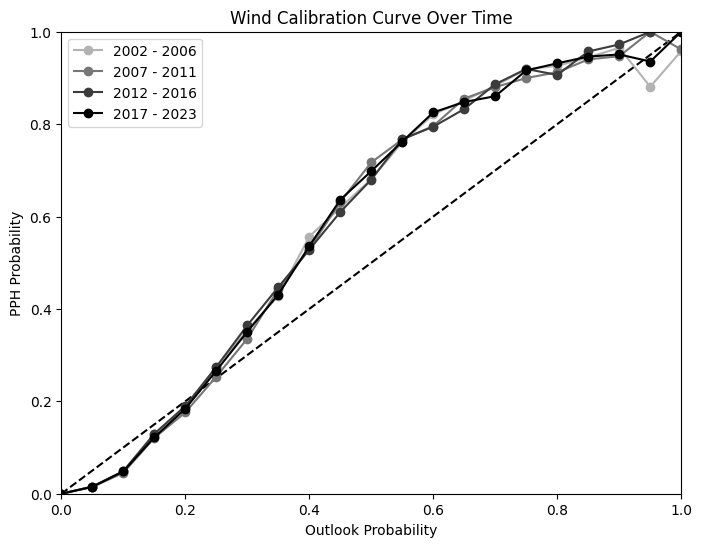

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


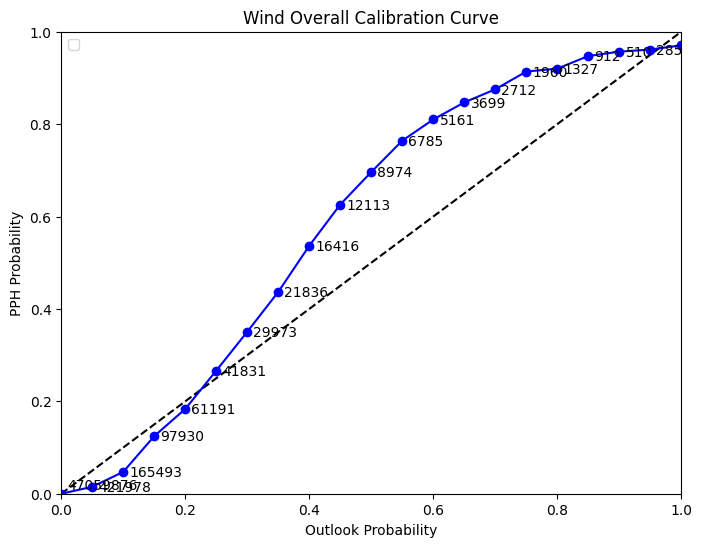

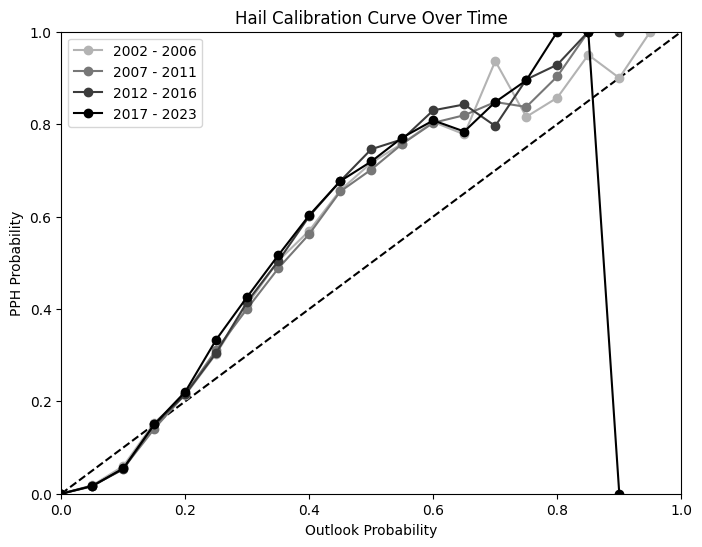

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


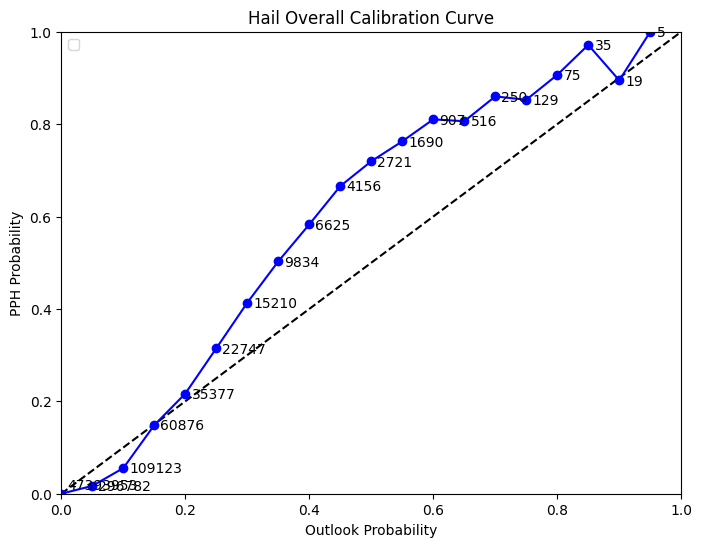

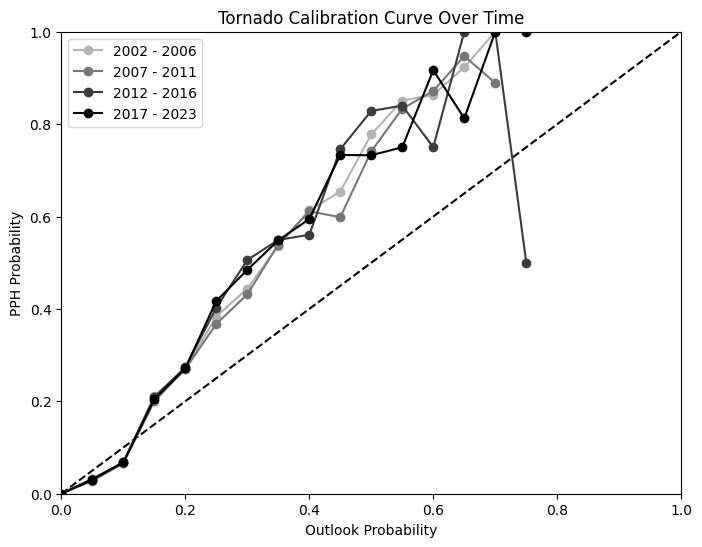

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


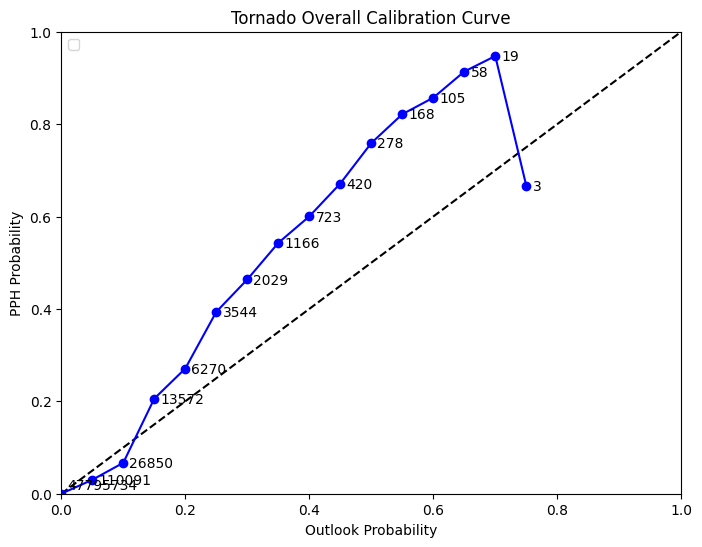

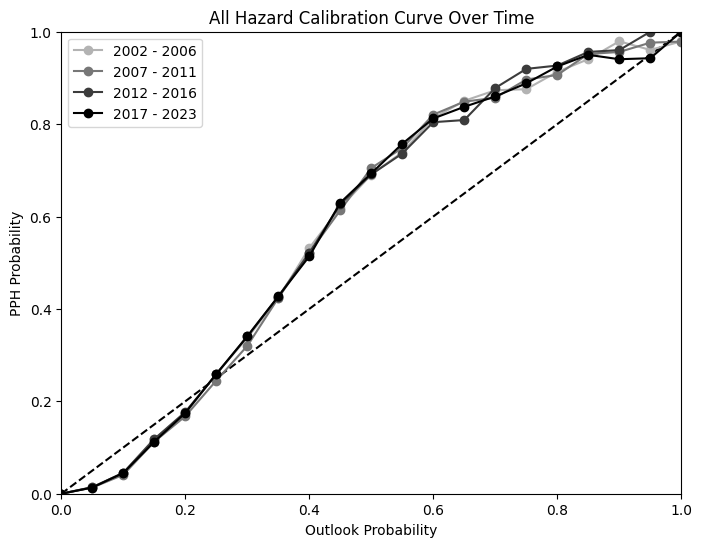

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


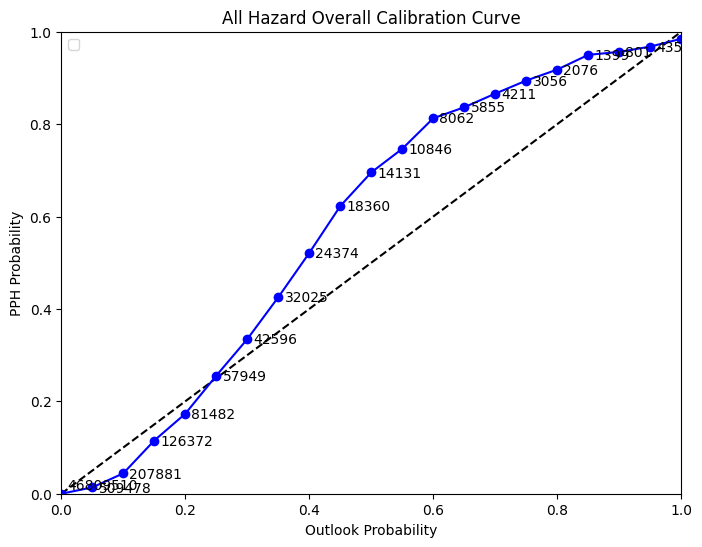

In [103]:
for haz in hazards:
    verification_probs = []
    forecast_probs = []
    labels = []
    colors = []
    greys = np.linspace(.7, 0, len(time_periods))
    for i, time_period in enumerate(time_periods):
        if time_period != 'all':
            year1 = time_period.split('_')[0]
            year2 = time_period.split('_')[1]
            this_verification = curr_verification.sel(time = (curr_verification['time'] >= year1 + '01010000') & (curr_verification['time'] <= year2 + '12312359'))
            this_forecast = curr_forecast.sel(time = (curr_forecast['time'] >= year1 + '01010000') & (curr_forecast['time'] <= year2 + '12312359'))
        else:
            year1 = '2002'
            year2 = '2023'
            this_verification = curr_verification
            this_forecast = curr_forecast

        #if binary_reports:
        #    pph_probs.append(this_pph.sel(hazard = pph_key_dict[haz])['bool'])
        #else:
        #    pph_probs.append(this_pph[pph_key_dict[haz]] / 100)
        #outlook_probs.append(this_outlooks.sel(outlook = outlook_key_dict[haz])['prob'])

        if contingency_type == '':
            verification_probs.append(this_verification[pph_key_dict[haz]] / 100)
            forecast_probs.append(this_forecast.sel(outlook = outlook_key_dict[haz])['prob'])

        elif contingency_type == 'binary_':
            verification_probs.append(this_verification.sel(hazard = reports_key_dict[haz])['bool'])
            forecast_probs.append(this_forecast.sel(outlook = outlook_key_dict[haz])['prob'])

        else: #optimal:
            verification_probs.append(this_verification.sel(hazard = reports_key_dict[haz])['bool'])
            forecast_probs.append(this_forecast[pph_key_dict[haz]] / 100)

        labels.append(year1 + ' - ' + year2)
        colors.append(str(greys[i]))
    #print(verification_probs.values(), forecast_probs.values())
    make_calibration_curve(verification_probs, forecast_probs, haz + ' Calibration Curve Over Time', labels, colors, save = True, save_title = (contingency_type + 'calibration_curve_' + haz + '_over_time' + ('_mdt' if mod else '_all')))

    #if binary_reports:
    #    overall_pph = curr_pph.sel(hazard = pph_key_dict[haz])['bool']
    #else:
    #    overall_pph = curr_pph[pph_key_dict[haz]] / 100

    if contingency_type == '':
        overall_verification = [curr_verification[pph_key_dict[haz]] / 100]
        overall_forecast = [curr_forecast.sel(outlook = outlook_key_dict[haz])['prob']]

    elif contingency_type == 'binary_':
        overall_verification = [curr_verification.sel(hazard = reports_key_dict[haz])['bool']]
        overall_forecast = [curr_forecast.sel(outlook = outlook_key_dict[haz])['prob']]

    else: #optimal:
        overall_verification = [curr_verification.sel(hazard = reports_key_dict[haz])['bool']]
        overall_forecast = [curr_forecast[pph_key_dict[haz]] / 100]

    
    make_calibration_curve(overall_verification, overall_forecast, haz + ' Overall Calibration Curve', [None], ['blue'], save = True, save_title = (contingency_type + 'calibration_curve_' + haz + ('_mdt' if mod else '_all')), counts = True)
